# Start

In v1, we split the data into our training and validation sets, created our dataloaders, applied transformations, and trained a model.

But the model was overfitting, so in version 2, we implemented auto-stopping to avoid it. In addition, we performed a number of optimizations that was missing in version 1, like training functions, better classification layers for the neural network, learning rate finder, etc.

The accuracy peaked at 67% in version 2. Next, we will try to increase that accuracy by using more complicated final layers, slightly higher dropout rates, more advanced transformations, possibly handle class imbalance, use test time augmentation, etc.

This version (version 3) will focus on the effect of using more complicated final layers and slightly higher dropout rates.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from torch.nn import functional as F

from typing import Dict, List, Tuple, Any
from tqdm.auto import tqdm
from copy import deepcopy

In [2]:
# for torchinfo
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [3]:
# for device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Get the dataset from Kaggle

Loading the full training data and taking a peek at one of them:

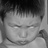

In [4]:
full_data = datasets.ImageFolder('/kaggle/input/train')
full_data[0][0]

In [5]:
full_data.classes[full_data[0][1]]

'angry'

Certainly looks angry to me.

# Split the data into train and validation sets and apply transformations

The dataset doesn't come with a validation set, but it's relatively easy to do it ourselves.

We know that the validation set has to be balanced and properly representative of the dataset, so we can randomly select a percentage of images from each label (folder) and then concatenate appropriately to form our validation set and new training set

I will create one of two functions for this:

- One to split the dataset, and/or
- one to save them in a new folder

1. fer_train_val:

Inputs:
- path (path containing the training dataset)
- valid_pct (percentage of data to use as validation)
- transforms (any transforms needed)


Process:

- Read in the training data and create the dataset
- Create datasets for each class
- Store datasets in a list
- Iterate over the list of datasets
- In each iteration:
  - compute the train/val sizes
  - randomly select the appropriate number of images for the sets
  - add the train set to a train list, and the val set to a val list

- At the end, concatenate the train set into a full train dataset, and the val set into a full val set

Things to consider:
- Exporting the data into a folder for download so as to reuse the same data and/or
- setting a random seed to ensure reusability (done)

This is a handy function I wrote to count the files in a directory. I especially used it in debugging the validation split function.

In [6]:
# create a function to count all files in a directory
def dir_len(path):
  """Counts all files in a directory."""
  total_files = 0
  for dirpath, dirnames, filenames in os.walk(path):
    total_files += len(filenames)
  return total_files

Here's the validation split function. It takes in the three parameters as laid out before and executes the steps.

One thing to note is that `transforms` is expected to be a list of transformations, with the first index being the train transformation and the second being the validation transformation.

In [7]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, random_split, Dataset, ConcatDataset
from collections import defaultdict
import os

def fer_train_val(path, valid_pct, transforms):

  # Step 1: Read data and create dataset
  dataset = ImageFolder(root=path, transform=transforms[0])

  # Step 2: Create datasets for each class:

  # - Mapping from class name to class index
  class_to_idx = dataset.class_to_idx
  idx_to_class = {v: k for k, v in class_to_idx.items()}

  # - Group indices by class (using string keys)
  class_indices = defaultdict(list)
  for i, (_, label) in enumerate(dataset.samples):
      class_indices[str(label)].append(i)

  # - Create a separate dataset for each class
  class_datasets = {}
  for class_idx_str, indices in class_indices.items():
      class_idx = int(class_idx_str)
      class_name = idx_to_class[class_idx]
      class_datasets[class_name] = Subset(dataset, indices)

  # Step 3: Store datasets in a list
  dataset_list = list(class_datasets.values())

  train_datasets = list()
  val_datasets = list()

  generator = torch.Generator().manual_seed(42) # setting the random seed

  # Step 4: Loop through dataset_list and compute the validation and training sets
  for class_ds in dataset_list:
    val_size = int(valid_pct * len(class_ds))  # valid_pct% for validation
    train_size = len(class_ds) - val_size  # remaining% for training
    train_dataset, val_dataset = random_split(class_ds, [train_size, val_size], generator=generator)
    train_datasets.append(train_dataset)
    val_datasets.append(val_dataset)

  # Step 5: Concatenate the datasets into train and val sets
  train = ConcatDataset(train_datasets)
  val = ConcatDataset(val_datasets)
  train.transform = transforms[0]
  val.transform = transforms[1]

  return train, val


Initialize the transformations for the training and validation sets:

In [8]:
import torchvision.transforms as T

train_transforms = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.RandomCrop(48, padding=4), # Random crop with padding
    T.RandomHorizontalFlip(),     # Randomly flip the image horizontally
    T.RandomRotation(degrees=10), # Randomly rotate the image by ±10 degrees
    # T.ColorJitter(brightness=0.2, contrast=0.2), # Optional: add brightness/contrast jitter
    T.ToTensor(),                 # Convert to PyTorch tensor (scales to 0-1)
    T.Normalize(mean=[0.5], std=[0.5]) # Normalize tensor
])

val_transforms = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.CenterCrop(48), # Center crop to the target size (if needed, otherwise just use Resize(48))
    T.ToTensor(),     # Convert to PyTorch tensor (scales to 0-1)
    T.Normalize(mean=[0.5], std=[0.5]) # Normalize tensor
])

Now, to initialize my training and validation sets:

In [9]:
train_data, val_data = fer_train_val('/kaggle/input/train', 0.2, [train_transforms,val_transforms])

And create the dataloaders:

In [10]:
train_loader = DataLoader(
    train_data,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_data,
    batch_size=4,
    shuffle=True,
    num_workers=2,
)

# Model Training - Resnet18

## Loading the model

Load the model:

In [11]:
from torchvision.models import resnet18, ResNet18_Weights

resnet_model = resnet18(weights=ResNet18_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 81.6MB/s]


## Preparing for fine tuning

~Freeze the base layers to focus on fine tuning~ Freezing made the accuracy drop far below v1, starting from 33 to 42% accuracy between epoch 1 and 12 (unlike 64 to 68 like in the simple v1).

Therefore, it appears that the base weights are not sufficient to classify emotions and need some fine-tuning as well.

In [12]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
# for param in resnet_model.parameters():
#     param.requires_grad = False

In [13]:
resnet_model.fc

Linear(in_features=512, out_features=1000, bias=True)

The final fully connected layer has 512 input features and 1000 output features, but we want it to output only 7 classes instead.

So we will replace this last layer with our own layer which will output only 7 outputs (one for each of our classes).

In [14]:
# Get the number of input features for the final fully connected layer
num_ftrs = resnet_model.fc.in_features
num_classes = 7 # no of classes in our data

# Replace the final fully connected layer
resnet_model.fc = nn.Sequential(
    # First hidden layer (Input: num_ftrs, Output: 512 nodes)
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5), # Slightly higher dropout rate example

    # Second hidden layer (Input: 512, Output: 256 nodes)
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5), # Apply dropout again

    # Output layer (Input: 256, Output: 7 classes)
    nn.Linear(256, 7)
)

# Move model to device
resnet_model.to(device)

resnet_model.fc

Sequential(
  (0): Linear(in_features=512, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=256, out_features=7, bias=True)
)

## Creating training and validation dataloaders

The resnet18 model is a pretrained model, so we have to transform our data into a form that is compatible with it. For example, the images in our dataset are grayscale (1 channel), but resnet18 was trained on 3-channel images.

In [15]:
# the original transforms for the model
ResNet18_Weights.DEFAULT.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


Here, we define new transforms specific to the resnet model to use with the fer_train_val function:

In [16]:
# ImageNet mean and std deviation (for 3 channels) - necessary because the pretrained model was trained with these
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
TARGET_SIZE = 224 # The spatial size expected by the pretrained ResNet-18 after transforms

# Transforms for the training set (includes augmentation)
train_transforms_resnet = T.Compose([
    T.Grayscale(num_output_channels=3), # Convert 1-channel grayscale to 3 channels by repeating
    T.Resize(256),                      # Resize the image (typically the shorter side) to 256
    T.RandomCrop(TARGET_SIZE),          # Take a random 224x224 crop for data augmentation
    T.RandomHorizontalFlip(),           # Standard data augmentation
    T.RandomRotation(degrees=10),       # add slight rotation
    T.ColorJitter(brightness=0.2, contrast=0.2), # add brightness/contrast jitter
    T.ToTensor(),                       # Convert PIL Image to PyTorch Tensor (scales to [0, 1])
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD) # Normalize with ImageNet values
])

# Transforms for the validation/testing set (deterministic preprocessing)
val_transforms_resnet = T.Compose([
    T.Grayscale(num_output_channels=3), # Convert 1-channel grayscale to 3 channels
    T.Resize(256),                      # Resize the image (typically the shorter side) to 256
    T.CenterCrop(TARGET_SIZE),          # Take the central 224x224 crop for evaluation
    T.ToTensor(),                       # Convert PIL Image to PyTorch Tensor (scales to [0, 1])
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD) # Normalize with ImageNet values
])


Then we again get our train and val sets:

In [17]:
resnet_train, resnet_val = fer_train_val('/kaggle/input/train', 0.2, [train_transforms_resnet,val_transforms_resnet])

Create the dataloaders:

In [18]:
batch_size = 32
resnet_trn_loader = DataLoader(resnet_train, batch_size=batch_size, shuffle=True, num_workers=2)
resnet_val_loader = DataLoader(resnet_val, batch_size=batch_size, shuffle=False, num_workers=2)

Define training functions for readability and reusability:

In [19]:
import sys
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               scheduler: torch.optim.lr_scheduler.OneCycleLR) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # 6. (added) Scheduler step
        scheduler.step()
        

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

# EDITED FOR PERFORMANCE AND TO IMPLEMENT EARLY STOPPING

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader, # Renamed from test_dataloader to val_dataloader for clarity with validation set
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          scheduler: torch.optim.lr_scheduler.OneCycleLR, # Type hint specific OneCycleLR as used
          device: torch.device,
          # --- Early Stopping Parameters ---
          patience: int = 10, # How many epochs to wait for improvement before stopping
          min_delta: float = 0.0 # Minimum change to qualify as improvement
          # ---------------------------------
         ) -> Dict[str, List[float]]:
    """Trains and tests a PyTorch model with Early Stopping.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop. Stops early if validation performance
    doesn't improve for 'patience' epochs.

    Calculates, prints and stores evaluation metrics throughout.
    Saves the best model state based on validation accuracy.

    Args:
        model: A PyTorch model to be trained and tested.
        train_dataloader: A DataLoader instance for the model to be trained on.
        test_dataloader: A DataLoader instance for the model to be validated on.
        optimizer: A PyTorch optimizer to help minimize the loss function.
        loss_fn: A PyTorch loss function to calculate loss on both datasets.
        epochs: An integer indicating how many epochs to train for (maximum).
        scheduler: A PyTorch learning rate scheduler (assumed to be stepped per batch).
        device: A target device to compute on (e.g. "cuda" or "cpu").
        patience: Number of epochs to wait for improvement in validation accuracy.
        min_delta: Minimum change in validation accuracy to be considered an improvement.

    Returns:
        A dictionary of training and testing loss as well as training and
        testing accuracy metrics tracked per epoch. The input 'model' object
        will be updated in-place with the best weights found during training
        (based on validation accuracy).
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [], # Renamed from test_loss to val_loss
               "test_acc": []  # Renamed from test_acc to val_acc
    }

    # --- Early Stopping Initialization ---
    best_val_accuracy = -float('inf') # Initialize best accuracy to a very low value
    patience_counter = 0             # Initialize patience counter
    best_model_state_dict = None     # To store the state_dict of the best model
    print(f"Early stopping configured with patience={patience}, min_delta={min_delta}")
    # ------------------------------------


    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        # Assuming train_step includes scheduler.step() per batch
        train_loss, train_acc = train_step(model=model,
                                             dataloader=train_dataloader,
                                             loss_fn=loss_fn,
                                             optimizer=optimizer,
                                             device=device,
                                             scheduler=scheduler) # Pass scheduler

        # Assuming test_step is your validation step
        val_loss, val_acc = test_step(model=model, # Renamed test_step calls to clarify validation
                                          dataloader=test_dataloader, # Using test_dataloader as val_dataloader
                                          loss_fn=loss_fn,
                                          device=device)

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | " # Renamed print output
            f"val_acc: {val_acc:.4f}"     # Renamed print output
        )

        # --- Early Stopping Logic ---
        # Check for improvement in validation accuracy
        if val_acc > best_val_accuracy + min_delta:
            best_val_accuracy = val_acc
            patience_counter = 0 # Reset patience counter on improvement
            # Save the model state dictionary
            # Use copy.deepcopy() to save a true copy, not just a reference
            best_model_state_dict = deepcopy(model.state_dict())
            print(f"  Validation accuracy improved. Saving best model state (Acc: {best_val_accuracy:.4f})")
        else:
            patience_counter += 1 # Increment patience counter if no improvement
            print(f"  Validation accuracy did not improve. Patience: {patience_counter}/{patience}")

        # Check if early stopping condition is met
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break # Exit the training loop

        # --- End Early Stopping Logic ---

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(val_loss) # Store as test_loss in results dict for consistency if needed later
        results["test_acc"].append(val_acc)   # Store as test_acc in results dict


    # --- Load the best model state after training stops ---
    if best_model_state_dict is not None:
        print("Loading best model state found during training.")
        model.load_state_dict(best_model_state_dict)
    else:
         print("No improvement was found during training. Using the model from the last epoch.")


    # Return the filled results at the end of the epochs
    return results

## Set up configuration

FastAI has good tools for hyperparameter tuning, so I will use it here:

In [20]:
# importing fastai
from fastai.vision.all import *

# defining the DataLoaders object in FastAI using both train and val datasets
dls = DataLoaders(resnet_trn_loader, resnet_val_loader)

# wrapping our dataloader in a fastai learner
learn = Learner(
    dls, resnet_model,
    loss_func=CrossEntropyLossFlat(), 
    opt_func=SGD,
    metrics=accuracy
)

SuggestedLRs(valley=0.02290867641568184)


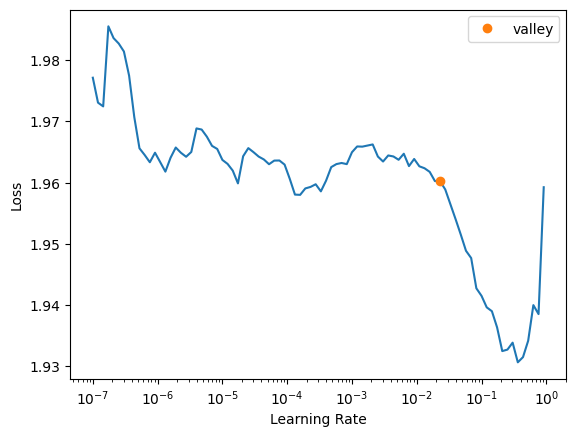

In [21]:
# finding the learning rate
lr_result = learn.lr_find()
print(lr_result)

In [22]:
lr = float(lr_result.valley)
lr

0.02290867641568184

In [23]:
# so we use that as our learning rate
learning_rate = lr

# define the criterion (loss function)
criterion = nn.CrossEntropyLoss()

# defining the optimizer, this time using SGD
optimizer = optim.SGD(
    resnet_model.parameters(),
    lr=lr,
    momentum=0.9,
    weight_decay=1e-4)

# define the number of epochs
num_epochs = 50

# adding a learning rate scheduler (OneCycleLR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=lr,
    steps_per_epoch=len(resnet_trn_loader),
    epochs=num_epochs)


## Now, we train

Actual training:

In [24]:
# Set number of epochs again for modularity
num_epochs = 50 

# set patience value for early stopping
patience_value = 10

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Call the training function with early stopping parameters
resnet18_results = train(model=resnet_model,
                         train_dataloader=resnet_trn_loader,
                         test_dataloader=resnet_val_loader,
                         optimizer=optimizer,
                         loss_fn=criterion,
                         epochs=num_epochs,
                         scheduler=scheduler,
                         device=device,
                         patience=patience_value,
                         min_delta=0.0001
                         )

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

Early stopping configured with patience=10, min_delta=0.0001


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5999 | train_acc: 0.3571 | val_loss: 1.2546 | val_acc: 0.5237
  Validation accuracy improved. Saving best model state (Acc: 0.5237)
Epoch: 2 | train_loss: 1.2553 | train_acc: 0.5227 | val_loss: 1.1389 | val_acc: 0.5701
  Validation accuracy improved. Saving best model state (Acc: 0.5701)
Epoch: 3 | train_loss: 1.1510 | train_acc: 0.5707 | val_loss: 1.0794 | val_acc: 0.5907
  Validation accuracy improved. Saving best model state (Acc: 0.5907)
Epoch: 4 | train_loss: 1.1120 | train_acc: 0.5926 | val_loss: 1.0267 | val_acc: 0.6185
  Validation accuracy improved. Saving best model state (Acc: 0.6185)
Epoch: 5 | train_loss: 1.0892 | train_acc: 0.6001 | val_loss: 1.0124 | val_acc: 0.6270
  Validation accuracy improved. Saving best model state (Acc: 0.6270)
Epoch: 6 | train_loss: 1.0856 | train_acc: 0.6024 | val_loss: 1.0662 | val_acc: 0.6128
  Validation accuracy did not improve. Patience: 1/10
Epoch: 7 | train_loss: 1.0635 | train_acc: 0.6147 | val_loss: 1.0609 | val

# Test Model - Resnet18

Load the test data:


In [25]:
test_dataset = ImageFolder(root='/kaggle/input/test', transform=val_transforms_resnet)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
)

In [26]:
from sklearn.metrics import classification_report

# Evaluate model
resnet_model.eval()
all_preds = []
all_labels = []

with torch.inference_mode():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification report as dictionary
report_dict = classification_report(
    all_labels, 
    all_preds, 
    target_names=full_data.classes, 
    output_dict=True
)

# Print report
print(classification_report(all_labels, all_preds, target_names=full_data.classes))


              precision    recall  f1-score   support

       angry       0.63      0.63      0.63       958
     disgust       0.81      0.71      0.76       111
        fear       0.56      0.52      0.54      1024
       happy       0.88      0.88      0.88      1774
     neutral       0.65      0.66      0.66      1233
         sad       0.56      0.58      0.57      1247
    surprise       0.80      0.82      0.81       831

    accuracy                           0.70      7178
   macro avg       0.70      0.69      0.69      7178
weighted avg       0.70      0.70      0.70      7178



Save model parameters:

In [27]:
torch.save(resnet_model.state_dict(), "./v3-resnet18.pt")